# Disaggregation

Implementation of the best evaluated model in the validation stage, corresponding to the FHMM model trained with average active power data collected every 30 seconds.

Libraries and other settings:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.utils import print_dict

labels = ['Main', 'Fryer', 'LED Lamp',  'Incandescent lamp','Laptop Computer', 'Fan']
colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan','tab:grey']

In [2]:
test = DataSet('ualm2.h5') #Pruebas

test.set_window(start="2023-02-24 18:51:28", end="2023-02-24 20:03:54")




test_elec = test.buildings[1].elec


test_Main=test_elec.mains() #medidor principal de cabecera
test_Main

ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[])

In [3]:
test_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
)

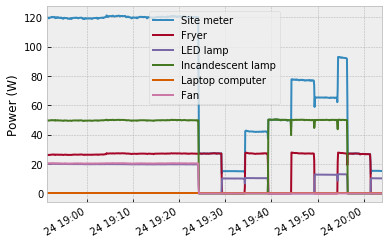

In [4]:
test_elec.plot()

Original signal vs disaggregated signal

We will use as the sampling period =30s

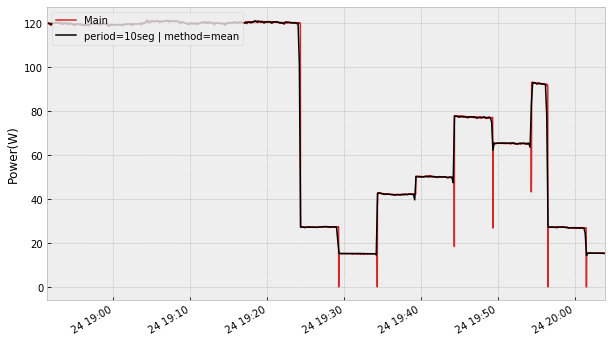

In [5]:
rcParams['figure.figsize'] = (10, 6)

ax1 = next(test_Main.load(ac_type='active', sample_period=1, resample_kwargs={'how':'first'})).plot(c='tab:red', lw=1.5) 
next(test_Main.load(ac_type='active', sample_period=10, resample_kwargs={'how':'mean'})).plot(ax=ax1, c='k', lw=1.5) 

ax1.legend([('Main'),'period=10seg | method=mean'], loc='upper left') #etiquetas
ax1.minorticks_off()   
ax1.set_ylabel('Power(W)')
#ax1.set(xticks=('2023-02-12 12:00:00+01:00', '2023-02-12 12:58:00+01:00'))
#ax1.set_xticklabels(labels=['11-10'], ha='left', rotation=0)    
plt.savefig('./data/images/6.1_Plot_test_30seg.svg', bbox_inches='tight', transparent=True)
pass

## Disaggregation

In [6]:
from nilmtk.legacy.disaggregate import FHMM
from nilmtk import HDFDataStore


train = DataSet('ualm2.h5')

train.set_window(start="2023-02-24 14:17:10", end="2023-02-24 17:40:00")
train_elec = train.buildings[1].elec

#Dispositivos para entrenamiento
train_Devices = train_elec.select(instance=[2,3,4,5,6])
train_Devices


#Set para validación
valid = DataSet('ualm2.h5')


valid.set_window(start="2023-02-24 17:40:01", end="2023-02-24 18:51:27")


valid_elec = valid.buildings[1].elec

print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)

print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[2,3,4,5,6])
print(valid_Devices)


#Vamos a  volver a ejecutar esto
#FHMM_test.import_model('C:/data/FHMM_30seg_median_model.pickle') #modelo FHMM elegido


from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM

#probad  10seg y mean con CO 58.7  a 28,9
#probad  15min nmedian CO 58,7a 28,9               
#probad  10seg first  CO 58,7 a 28,9

#periods = { '30seg':30} #old
#periods = {'10seg':10}
periods = { '60seg':60}
#periods = { '5min':300}
#periods = { '10min':600}
#periods = { '15min':900}
#periods = { '30min':1800}


methods = [ 'median']
#mhods = [ 'first'] #old
#methods = [ 'mean']

times = {}

data_dir = './data/'
times = {} #almacena tiempos de ejecución
null={} #diccionario nulo


for sp_name, sp in periods.items():
    t = []
    for method in methods:
       # models={'FHMM':FHMM()} #old
        models={'CO':CombinatorialOptimisation()}
        for model_name, model in models.items():
            model.MIN_CHUNK_LENGTH = 1   
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)   
            import time
            start = time.time()
            model.train(train_Devices,
                num_states_dict={}, #diccionario de estados nulo, por defecto
                ac_type='active', #potencia activa, por defecto
                sample_period=30, #cambio de muestreo
                resample_kwargs={'how':'mean'})#método
                

            t.append(round(time.time()-start,2)) #tiempo de simulación

            #Guardamos el  modelo entrenado
            #Falla  al exprtarlo como model.pickle asi que lo salvamos en formato h5
            #model_dir = dir_models + model_name + '_1s_first_model.pickle'
            #print(model_dir)
            #model.export_model(model_dir) 
            output=HDFDataStore(data_dir+'NILM/Results/test_results.h5', 'w')
            
            model.disaggregate(valid_Main, output, sample_period=sp, resample_kwargs={'how':method}, ac_type='active')
            output.close()
            end = time.time()-start
            t.append(round(end,2))  

    times[sp_name] = t

  
            
    
print('\n\nDone!')



Medidor de cabecera para desagregación:
ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[])

Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
)
******************** CO 60seg median********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', applian

In [7]:
file=open (data_dir+'NILM/Results/test_results.h5')

file.close()

### Results

In [8]:
results=DataSet(data_dir+'NILM/Results/test_results.h5')
results_elec=results.buildings[1].elec # Todos los medidores
results_Main=results_elec.mains() #medidor de cabecera
results_Devices=results_elec.submeters() #predicciones

results_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='CO', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='CO', appliances=[Appliance(type='fryer', instance=1)])
  ElecMeter(instance=3, building=1, dataset='CO', appliances=[Appliance(type='LED lamp', instance=1)])
  ElecMeter(instance=4, building=1, dataset='CO', appliances=[Appliance(type='incandescent lamp', instance=1)])
  ElecMeter(instance=5, building=1, dataset='CO', appliances=[Appliance(type='laptop computer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='CO', appliances=[Appliance(type='fan', instance=1)])
)

### Metadata

In [9]:
print_dict(results.metadata)

In [10]:
print_dict(results.buildings[1].metadata)

In [11]:
print_dict(results_elec[1].get_metadata())

## Graphical Analysis

### All results

6/6 ElecMeter(instance=6, building=1, dataset='CO', appliances=[Appliance(type='fan', instance=1)])nstance=1)])])

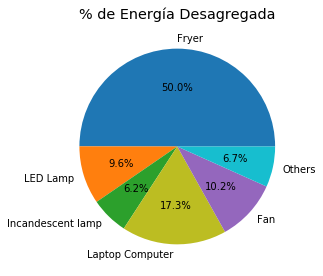

In [12]:
d1=results_elec.fraction_per_meter()
ax1=d1.plot(autopct=lambda p:'{:.1f}%'.format(p), kind='pie',
            labels=labels[1:]+list(['Others']), figsize=(4.5,4.5),
            colors=colors)
ax1.set(ylabel="")
ax1.set(title='% de Energía Desagregada')
#guarda gráfico
plt.savefig('./data/images/6.2_Plot_results_1.1.svg', bbox_inches='tight', transparent=True)

5/5 ElecMeter(instance=6, building=1, dataset='CO', appliances=[Appliance(type='fan', instance=1)])nstance=1)])]))])

[Text(0.5, 1.0, 'Pred')]

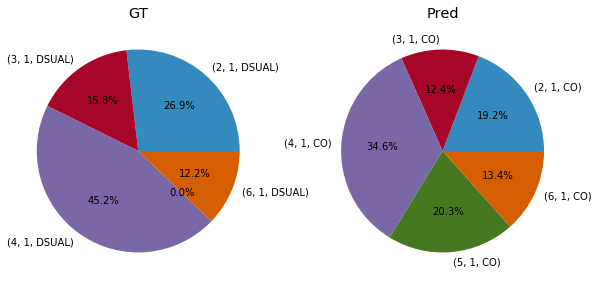

In [13]:
#rcParams['figure.figsize'] = (58, 55)
fig, (ax1, ax2) = plt.subplots(1, 2)
test_elec.select(instance=[2,3,4,5,6]).fraction_per_meter().plot(ax=ax1, autopct=lambda p:'{:.1f}%'.format(p), kind='pie')
#val_elec.select(instance=[2,3,4,5,6]).fraction_per_meter().plot(ax=ax1, autopct=lambda p:'{:.1f}%'.format(p), kind='pie')

results_elec.select(instance=[2,3,4,5,6]).fraction_per_meter().plot(ax=ax2, autopct=lambda p:'{:.1f}%'.format(p), kind='pie')
ax1.set(ylabel="")
ax1.set(title='GT')
ax2.set(ylabel="")
ax2.set(title='Pred')

(-100, 3200)

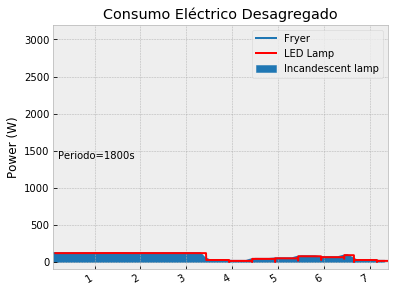

In [14]:

rcParams['figure.figsize'] = (6, 5)

df_d=test_elec.select(instance=[1]).dataframe_of_meters(ac_type='active')
ax1 = df_d.plot(kind='area',color=colors) 
next(test_elec[1].load(ac_type='active')).plot(ax=ax1, c='r')

#etiquetas
ax1.legend(labels[1:7])
ax1.set(title='Consumo Eléctrico Desagregado')
ax1.set_xticklabels(['1','2', '3', '4','5','6','7', '8','9'])
ax1.set(ylabel='Power (W)')
ax1.annotate("Periodo=1800s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,3200)

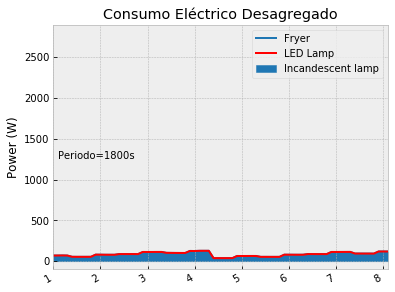

In [15]:
rcParams['figure.figsize'] = (6, 5)

df_d=results_elec.select(instance=[1]).dataframe_of_meters(ac_type='active')
ax1 = df_d.plot(kind='area',color=colors) 
next(results_elec[1].load()).plot(ax=ax1, c='r')

#etiquetas
ax1.legend(labels[1:7])
ax1.set(title='Consumo Eléctrico Desagregado')
ax1.set_xticklabels(['1','2', '3', '4','5','6','7', '8','9'])
ax1.set(ylabel='Power (W)')
ax1.annotate("Periodo=1800s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,2900)
#guarda gráfico
plt.savefig('./data/images/6.3_Plot_results_1.2.svg', bbox_inches='tight', transparent=True)
pass

In [16]:
#Energía de dispositivos
e_d=round(results_elec.energy_per_meter().transpose()['active'][1:],1)
print('\n\nEnergía de Dispositivos:')
print(e_d)

#Energía total de dispositivos
e_t=round(sum(e_d),2)
print('\nEnergía Total Dispositivos: '+str(e_t))

#energía medida por Mains_RST
e_m=round(results_elec.mains().total_energy(),1)
print('\nEnergía Main Principal: '+str(e_m[0]))

#energía no medida
print('\nEnergía No medida: '+str(e_m[0]-e_t))

6/6 ElecMeter(instance=6, building=1, dataset='CO', appliances=[Appliance(type='fan', instance=1)])nstance=1)])])

Energía de Dispositivos:
(2, 1, CO)    0.0
(3, 1, CO)    0.0
(4, 1, CO)    0.0
(5, 1, CO)    0.0
(6, 1, CO)    0.0
Name: active, dtype: float64

Energía Total Dispositivos: 0.0

Energía Main Principal: 0.1

Energía No medida: 0.1


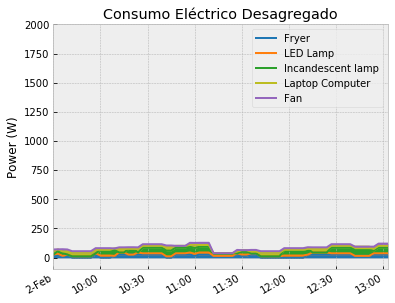

In [17]:
rcParams['figure.figsize'] = (6, 5)

df_d=results_elec.select(instance=[2,3,4,5,6]).dataframe_of_meters(ac_type='active')

ax1 = df_d.plot(kind='area',color=colors)   
#etiquetas
ax1.legend(labels[1:7])
ax1.set(title='Consumo Eléctrico Desagregado')
ax1.set_xticklabels(['2-Feb','10:00', '10:30', '11:00','11:30','12:00','12:30', '13:00','13:15'])
ax1.set(ylabel='Power (W)')
#ax1.annotate("Periodo=30s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,2000)
#guarda gráfico
plt.savefig('./data/images/6.3_Plot_results_1.2.svg', bbox_inches='tight', transparent=True)